In [13]:
import random
import pandas as pd
import numpy as np
import warnings
import os
import random
import matplotlib.pyplot as plt
from tqdm import trange
import datetime, time
from utils import *
from collections import Counter
from scipy import *
import scipy.io as scio
import tensorflow as tf
import logging

from tslearn.datasets import CachedDatasets
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn import preprocessing

from deepwalk import graph
from deepwalk import walks as serialized_walks
import weighted_random_walk
from gensim.models import Word2Vec
from skipgram import Skipgram
import networkx as nx

import psutil
from multiprocessing import cpu_count

warnings.filterwarnings('ignore')

In [264]:
undirected = False
input_format = 'edgelist'
log_verb = 'INFO'
representation_size = 64   # Number of latent dimensions to learn for each node
workers = 2          # Number of parallel processes
window_size = 5      # Window size of skipgram model
walk_length = 100     # Length of the random walk started at each node
number_walks = 10    # Number of random walks to start at each node
seed = 0             # random seed
shp_len = 10         # shapelet length
shp_num = 100        # number of shapelet in each time series
postive_per = 0.6    # the postive samples rate in dataset
# dis_type = 'JS'      #KL or JS or EMD
max_memory_data_size = 1000000000

## 补全时间序列

In [265]:
# dict_ts = get_all_files_ts()

In [266]:
#保存
# np.save('./data/money_laundrying_dataset/TS_amt_bal_dest.npy', dict_ts)

## 计算shapelet

In [267]:
data = np.load('./data/money_laundrying_dataset/gx_data_{}.npy'.format(str(postive_per)), allow_pickle=True)[()]
X = data['X']
y = data['y']
ts = data['ts']
print(X.shape, y.shape, ts.shape)

(1250, 1000, 1) (1250,) (1250, 1000, 2)


In [268]:
per = sum(y)/y.shape[0]
print('Dataset Percentage of Postive Samples = {}'.format(per))

Dataset Percentage of Postive Samples = 0.6


In [269]:
# Scaler
X = preprocessing.scale(X.squeeze())
X = X[:,:,np.newaxis]
print(X.shape)

(1250, 1000, 1)


In [270]:
n_ts, ts_sz = X.shape[:2]
n_classes = len(set(y))
print(n_ts, ts_sz, n_classes)

1250 1000 2


In [271]:
# shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
#                                                        ts_sz=ts_sz,
#                                                        n_classes=n_classes,
#                                                        l=0.1,
#                                                        r=1)
shapelet_sizes = {shp_len: shp_num}
shapelet_sizes

{10: 100}

In [272]:
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=100,
                            random_state= 42,
                            verbose=1)
shp_clf.fit(X, y)

Epoch 1/100
79/79 [==============================] - 0s 4ms/step - loss: 9.0292 - binary_accuracy: 0.5608 - binary_crossentropy: 9.0101
Epoch 2/100
79/79 [==============================] - 0s 4ms/step - loss: 4.8845 - binary_accuracy: 0.5688 - binary_crossentropy: 4.8659
Epoch 3/100
79/79 [==============================] - 0s 4ms/step - loss: 2.5988 - binary_accuracy: 0.5760 - binary_crossentropy: 2.5806
Epoch 4/100
79/79 [==============================] - 0s 4ms/step - loss: 3.5784 - binary_accuracy: 0.5712 - binary_crossentropy: 3.5605
Epoch 5/100
79/79 [==============================] - 0s 4ms/step - loss: 3.4825 - binary_accuracy: 0.5936 - binary_crossentropy: 3.4648
Epoch 6/100
79/79 [==============================] - 0s 4ms/step - loss: 2.3053 - binary_accuracy: 0.5704 - binary_crossentropy: 2.2879
Epoch 7/100
79/79 [==============================] - 0s 4ms/step - loss: 3.0331 - binary_accuracy: 0.5576 - binary_crossentropy: 3.0160
Epoch 8/100
79/79 [=============================

79/79 [==============================] - 0s 4ms/step - loss: 1.8734 - binary_accuracy: 0.5800 - binary_crossentropy: 1.8587
Epoch 61/100
79/79 [==============================] - 0s 4ms/step - loss: 1.9375 - binary_accuracy: 0.5936 - binary_crossentropy: 1.9230
Epoch 62/100
79/79 [==============================] - 0s 4ms/step - loss: 2.0393 - binary_accuracy: 0.5904 - binary_crossentropy: 2.0247
Epoch 63/100
79/79 [==============================] - 0s 4ms/step - loss: 2.0327 - binary_accuracy: 0.5992 - binary_crossentropy: 2.0183
Epoch 64/100
79/79 [==============================] - 0s 4ms/step - loss: 1.8971 - binary_accuracy: 0.5880 - binary_crossentropy: 1.8827
Epoch 65/100
79/79 [==============================] - 0s 4ms/step - loss: 1.8528 - binary_accuracy: 0.5888 - binary_crossentropy: 1.8384
Epoch 66/100
79/79 [==============================] - 0s 4ms/step - loss: 3.7270 - binary_accuracy: 0.5768 - binary_crossentropy: 3.7126
Epoch 67/100
79/79 [==============================] - 

LearningShapelets(batch_size=16, max_iter=100, n_shapelets_per_size={10: 100},
                  optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f2acf846df0>,
                  random_state=42, verbose=1, weight_regularizer=0.01)

In [273]:
# the performance of shapelet may influence the final result of our model
pred_labels = shp_clf.predict(X)
print("accuracy:", accuracy_score(y, pred_labels))
print("precision:", precision_score(y, pred_labels))
print('recall:', recall_score(y, pred_labels))
print('f1-score:', f1_score(y, pred_labels))

79/79 [==============================] - 0s 1ms/step
accuracy: 0.6
precision: 0.6
recall: 1.0
f1-score: 0.7499999999999999


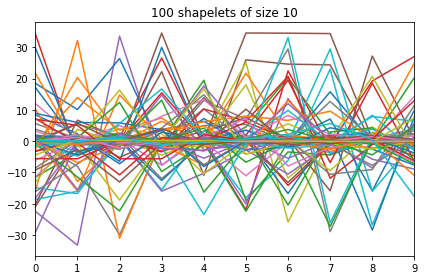

In [274]:
# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])
    #plt.ylim([0,10000])
plt.tight_layout()
plt.show()

In [275]:
#shp_clf.shapelets_.shape
shp_loc = shp_clf.locate(X)
shp_loc.shape

79/79 [==============================] - 0s 1ms/step


(1250, 100)

In [276]:
shp_ts = shp_clf.shapelets_as_time_series_
shp_ts.shape

(100, 10, 1)

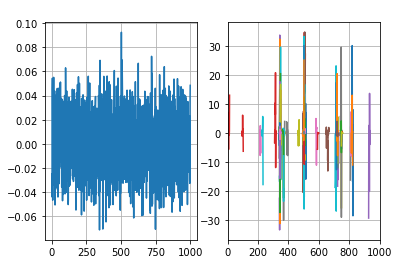

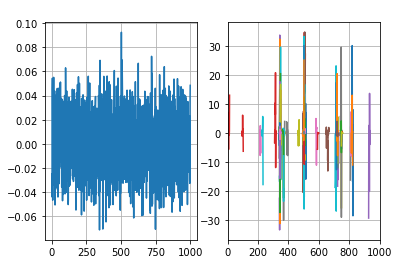

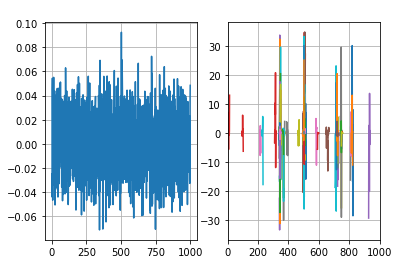

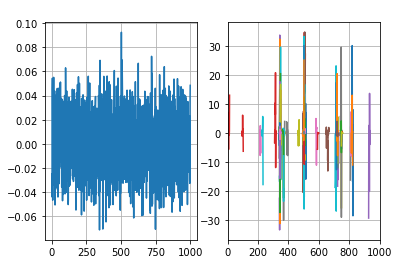

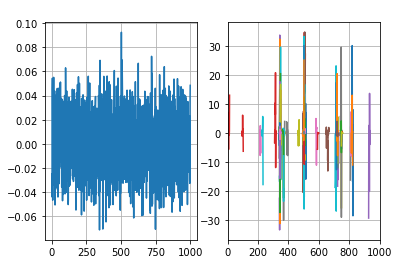

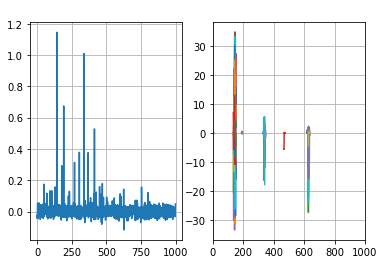

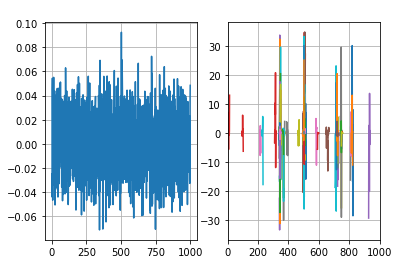

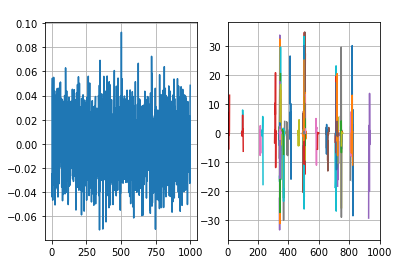

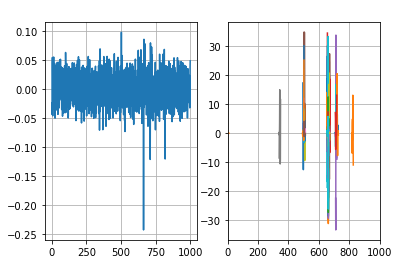

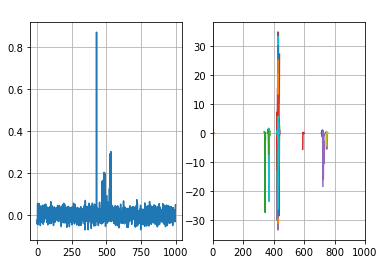

In [277]:
##plot
#the shapelets in timeseries
for i in range(X.squeeze().shape[0])[:10]:
    plt.subplot(1,2,1)
    x = list(range(X.shape[1]))
    values = list(X.squeeze()[i,:])
    plt.plot(x, values, label = 'ts')
    plt.grid()
    plt.title('time series', color='white')
    #plt.show()
    plt.subplot(1,2,2)
    plt.grid()
    for j in range(shp_ts.shape[0]):
        x = list(range(shp_loc[i,j], shp_loc[i,j]+shp_ts.shape[1]))
        values = list(shp_ts[j])
        plt.plot(x, values, label = 'shapelets'+str(j))
        plt.xlim(0, X.shape[1])
        plt.title('shapelet', color='white') 
    #plt.xlim(0,1000)
    #plt.ylim(-10000,10000)
    #plt.legend()
    plt.show()

In [278]:
# the shapelet sequence of each time series
df_shp_loc = pd.DataFrame(shp_loc)
shp_seqs = []
for row in range(df_shp_loc.shape[0]):
    shp_seq = df_shp_loc.sort_values(by=[row], axis=1).columns.tolist()
    shp_seqs.append(shp_seq)
shp_seqs = np.array(shp_seqs)
print(shp_seqs.shape)

(1250, 100)


In [279]:
d_shp = dict()
d_shp['shp_loc'] = shp_loc
d_shp['shp_ts'] = shp_ts
d_shp['shp_seq'] = shp_seqs
d_shp['seq_label'] = y
np.save('./data/money_laundrying_dataset/shp_{}_{}/shp_loc_ts_{}.npy'.format(shp_len, shp_num, str(postive_per)), d_shp)

## DTW距离

In [280]:
#已经训练好的shapelet与原序列的对应位置和shapelet本身
shp_loc_ts = np.load('./data/money_laundrying_dataset/shp_{}_{}/shp_loc_ts_{}.npy'.format(shp_len, shp_num, str(postive_per)),\
                    allow_pickle=True)[()]
shp_loc_ts.keys()

dict_keys(['shp_loc', 'shp_ts', 'shp_seq', 'seq_label'])

In [281]:
shp_loc = shp_loc_ts['shp_loc']
shp_ts = shp_loc_ts['shp_ts']
shp_seq = shp_loc_ts['shp_seq']
seq_label = shp_loc_ts['seq_label']
print(shp_loc.shape, shp_ts.shape, shp_seq.shape, seq_label.shape)

(1250, 100) (100, 10, 1) (1250, 100) (1250,)


In [282]:
shp_num = shp_ts.shape[0]
shp_len = shp_ts.shape[1]
print(shp_num, shp_len)

100 10


In [283]:
ts_num = X.shape[0]
w_amt_mat = []
for i in trange(ts_num):
    w_amt = []
    for j in range(shp_num):
        x_amt = X[i, shp_loc[i, j]:shp_loc[i, j]+shp_len, 0]
        y_amt = shp_ts[j,:,0]
        d_amt = dtw_distance(x_amt, y_amt)
        w_amt.append(d_amt)
    w_amt_mat.append(w_amt)
w_amt_mat = np.array(w_amt_mat)
dtw_mat = w_amt_mat
dtw_mat.shape

100%|██████████| 1250/1250 [00:20<00:00, 60.21it/s]


(1250, 100)

In [284]:
# save the result
d_weight = dict()
d_weight['dtw_mat'] = dtw_mat
np.save('./data/money_laundrying_dataset/shp_{}_{}/tmp_unweight_mat_{}.npy'.format(shp_len, shp_num, str(postive_per)), d_weight)

In [285]:
# the dtw threshold should not be too small, or there will exist isolate node in Graph,
# meanwhile, it should not be too large as well, because it will be meaningless to set threshold
dtw_threshold = np.mean(dtw_mat)+27
dtw_threshold

60.913104910665915

In [286]:
# if the shapelet can fit time series well(the discrepancy larger than threshold),
# then this shaplet should be delete from the shp_seq(use -1 to represent)
for i in trange(ts_num):
    for j in range(shp_num):
        if dtw_mat[i,j] > dtw_threshold: 
            shp_seq[i, j] = -1  
# update the shaplet sequence of time series
shp_loc_ts['shp_seq'] = shp_seq
# np.save('./data/money_laundrying_dataset/shp_{}_{}/shp_loc_ts.npy'.format(shp_len, shp_num), shp_loc_ts)

100%|██████████| 1250/1250 [00:00<00:00, 28853.01it/s]


## 构造有向图

In [287]:
weight_mat = np.load('./data/money_laundrying_dataset/shp_{}_{}/tmp_unweight_mat_{}.npy'.format(shp_len, shp_num,str(postive_per)),\
                     allow_pickle=True)
weight_mat = weight_mat[()]
weight_mat.keys()

dict_keys(['dtw_mat'])

In [288]:
dtw_mat = weight_mat['dtw_mat']
# freq_mat = weight_mat['freq_mat']
print(dtw_mat.shape)
#dest time series
dest_ts = ts[:,:,1]
print(dest_ts.shape)

(1250, 100)
(1250, 1000)


In [289]:
# calculate weight
INF = 1e10
shp_n = shp_loc.shape[1]
edge_mat = np.zeros(shp_n * shp_n)
edge_mat = edge_mat.reshape(shp_n, shp_n)
    
for i in trange(shp_seq.shape[0]):
    for j in range(1,shp_seq.shape[1]):
        if dtw_mat[i, j-1] > dtw_threshold or dtw_mat[i, j] > dtw_threshold:
            continue
        edge_mat[shp_seq[i,j-1]][shp_seq[i,j]] = 1
edge_mat = np.array(edge_mat)

100%|██████████| 1250/1250 [00:00<00:00, 6731.67it/s]


In [290]:
# There should not exist ioslate node, if it does, please adjust Variable 'dtw_threshold'
cnt = 0
for i in range(edge_mat.shape[0]):
    flag = 0 
    for j in range(edge_mat.shape[1]):
        if edge_mat[i,j] != 0:
            flag = 1
            break
    if flag == 0:
        cnt += 1
print('There exists {} isolate shapelets'.format(cnt))

There exists 0 isolate shapelets


In [291]:
edgelist = []
for i in range(shp_num):
    for j in range(shp_num):
        w = edge_mat[i,j]
        if w != 0:
            edgelist.append((i,j))
print('{} edges in Graph'.format(len(edgelist)))

5998 edges in Graph


In [292]:
G = nx.DiGraph()
G.add_edges_from(edgelist)

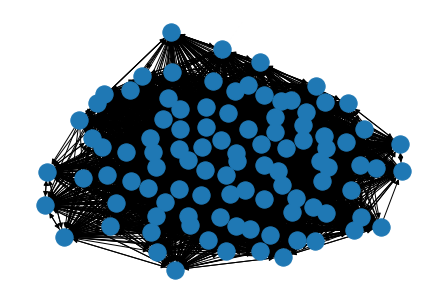

In [293]:
pos = nx.spring_layout(G)
nx.draw(G, pos)
plt.show()

In [294]:
# save the graph
nx.write_edgelist(G, "./data/money_laundrying_dataset/shp_{}_{}/unweighted_{}.edgelist"\
                           .format(shp_len, shp_num, str(postive_per)))

## DeepWalk

In [295]:
p = psutil.Process(os.getpid())
p.cpu_affinity(list(range(cpu_count())))

In [296]:
logger = logging.getLogger(__name__)
LOGFORMAT = "%(asctime).19s %(levelname)s %(filename)s: %(lineno)s %(message)s"
numeric_level = getattr(logging, log_verb.upper(), None)
logging.basicConfig(format=LOGFORMAT)

In [297]:
input_file = './data/money_laundrying_dataset/shp_{}_{}/unweighted_{}.edgelist'.format(shp_len, shp_num,str(postive_per))

In [298]:
if input_format == "adjlist":
    G = graph.load_adjacencylist(input_file, undirected=undirected)
elif input_format == "edgelist":
    G = graph.load_edgelist(input_file, undirected=undirected)
elif input_format == "mat":
    G = graph.load_matfile(input_file, variable_name=matfile_variable_name, undirected=undirected)
elif input_format == 'weighted_edgelist':
    G = nx.DiGraph()
    G.add_weighted_edges_from(edgelist)
else:
    raise Exception("Unknown file format: '%s'.  Valid formats: 'adjlist',\
    'edgelist', 'mat', 'weighted_edgelist'" % input_format)

In [299]:
num_walks = len(G.nodes()) * number_walks
data_size = num_walks * walk_length
print("Number of nodes: {}".format(len(G.nodes())))
print("Number of walks: {}".format(num_walks))
print("Data size (walks*length): {}".format(data_size))

if data_size < max_memory_data_size:
    print("Walking...")
    if input_format == 'weighted_edgelist':
        walks = weighted_random_walk.random_walk(G, num_paths=number_walks,path_length=walk_length, alpha=0)
        for i in range(len(walks)):
            walk = walks[i]
            walk = [str(val) for val in walk]
            walks[i] = walk
    else:
        walks = graph.build_deepwalk_corpus(G, num_paths=number_walks,path_length=walk_length, alpha=0)
    print("Training...")
    model = Word2Vec(walks, size=representation_size, window=window_size, min_count=0, workers=workers)
#   model.save_word2vec_format(output)
    print('Finished')

Number of nodes: 100
Number of walks: 1000
Data size (walks*length): 100000
Walking...
Training...
Finished


In [300]:
#save the model
t = time.localtime()
tt = str(t.tm_year)+str(t.tm_mon).zfill(2)+str(t.tm_mday).zfill(2)+str(t.tm_hour).zfill(2)+str(t.tm_min).zfill(2)
output_file = './experiments/time2graph/model_embedding_{}_{}.embeddings'.format(str(postive_per), tt)
model.wv.save_word2vec_format(output_file)

## 获取序列的embedding

In [301]:
shp_loc_ts = np.load('./data/money_laundrying_dataset/shp_{}_{}/shp_loc_ts_{}.npy'.format(shp_len, shp_num,str(postive_per))\
                    ,allow_pickle = True)[()]
shp_loc_ts.keys()

dict_keys(['shp_loc', 'shp_ts', 'shp_seq', 'seq_label'])

In [302]:
shp_loc = shp_loc_ts['shp_loc']
shp_ts = shp_loc_ts['shp_ts']
shp_seq = shp_loc_ts['shp_seq']
seq_label = shp_loc_ts['seq_label']
print(shp_loc.shape, shp_ts.shape, shp_seq.shape, seq_label.shape)

(1250, 100) (100, 10, 1) (1250, 100) (1250,)


In [303]:
def read_shp_emb(emb_file):
    # return type:dict
    with open(emb_file) as emb:
        data = emb.readlines()
        shp_num, shp_dim = [int(val) for val in str.split(data[0].strip('\n'))]
        dict_embs = dict()
        for i in range(1, shp_num+1):
            tmp = str.split(data[i].strip('\n'))
            key = tmp[0]
            emb = [float(val) for val in tmp[1:]]
            dict_embs[key] = emb
    return dict_embs

In [304]:
emb_file = './experiments/time2graph/model_embedding_0.6_202105171556.embeddings'
dict_shp_embs = read_shp_emb(emb_file)

In [305]:
dtw_mat.shape

(1250, 100)

In [306]:
# get seq embeddings with the constrain of DTW threshold
dict_seq_embs = dict()
ts_num = shp_seq.shape[0]
for i in trange(ts_num):
    seq = [val for val in shp_seq[i,:] if val!=-1]
    for j in range(len(seq)):
        p = (np.max(dtw_mat[:,seq[j]]) - dtw_mat[i, seq[j]]) / (np.max(dtw_mat[:,seq[j]]) - np.min(dtw_mat[:,seq[j]]))
        if i not in dict_seq_embs.keys():
            dict_seq_embs[i] = np.array(dict_shp_embs[str(seq[j])]) * p
        else:
            dict_seq_embs[i] += np.array(dict_shp_embs[str(seq[j])]) * p

100%|██████████| 1250/1250 [00:03<00:00, 361.87it/s]


## Classifier

In [307]:
# features_matrix = np.asarray([model[str(node)] for node in range(len(G.nodes()))])
features_matrix = pd.DataFrame(dict_seq_embs).values.T
features_matrix.shape

(1250, 64)

In [308]:
X = features_matrix
y = seq_label
#print(X.shape, y.shape)
X_train,X_test,y_train,y_test = train_test_split(X,y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(937, 64) (313, 64) (937,) (313,)


In [309]:
### Xgboost Classifier
model = XGBClassifier()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print('XGBoost')
print("accuracy:",accuracy_score(y_test,predictions))
print("precision:", precision_score(y_test, predictions))
print("f1-score", f1_score(y_test, predictions))

XGBoost
accuracy: 0.6996805111821086
precision: 0.6877470355731226
f1-score 0.7873303167420815


In [310]:
### Logistic Regression Classifier 
clf = LogisticRegression(penalty='l2')
clf.fit(X_train,y_train)
predictions = clf.predict(X_test)
print("Logistic Regression")
#print(classification_report(y_test,predictions))
print("accuracy:",accuracy_score(y_test,predictions))
print("precision:", precision_score(y_test, predictions))
print("f1-score", f1_score(y_test, predictions))

Logistic Regression
accuracy: 0.6261980830670927
precision: 0.8050847457627118
f1-score 0.6188925081433225


In [311]:
### Decision Tree
rfc = DecisionTreeClassifier()
rfc = rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)
print('Decision Tree')
print("accuracy:",accuracy_score(y_test,predictions))
print("precision:", precision_score(y_test, predictions))
print("f1-score", f1_score(y_test, predictions))

Decision Tree
accuracy: 0.6996805111821086
precision: 0.6907630522088354
f1-score 0.7853881278538813


In [312]:
### Extra Tree
clf = ExtraTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print('Extra Tree')
print("accuracy:",accuracy_score(y_test,predictions))
print("precision:", precision_score(y_test, predictions))
print("f1-score", f1_score(y_test, predictions))

Extra Tree
accuracy: 0.6837060702875399
precision: 0.6717557251908397
f1-score 0.7804878048780488
